# P5


In [1]:
import pandas as pd
import numpy as np

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')


In [2]:
# comment out if don't want to run the preparation notebook
# %run data_process.ipynb

In [3]:
with open('docs_reduced_body', 'rb') as f:
    docs_reduced_body = pickle.load(f)
    f.close()
with open('docs_reduced_body_sentences', 'rb') as f:
    docs_reduced_body_sentences = pickle.load(f)
    f.close()

with open('docs_tags', 'rb') as f:
    docs_tags = pickle.load(f)
    f.close()

with open('common_words', 'rb') as f:
    common_words = pickle.load(f)
    f.close()

with open('common_tags', 'rb') as f:
    common_tags = pickle.load(f)
    f.close()


## MultiLabel Binarizer

### Tags

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_t = MultiLabelBinarizer()
mlb_b = MultiLabelBinarizer()

def mlb_tags():
    # fit the mlb with common tags (200)
    print(f'fitting multilabel binarizer for common tags (len: {len(common_tags)})')
    mlb_t.fit([common_tags])
    print(mlb_t.classes_.shape)
    # docs['mlb_tags'] = mlb_t.transform(docs.tags).tolist()
    return mlb_t

def mlb_body():
    print(f'fitting multilabel binarizer for corpus common words (len: {len(common_words)})')
    mlb_b.fit([common_words])
    print(mlb_b.classes_.shape)
    # docs['mlb_reduced_body'] = mlb_b.transform(docs.reduced_body).tolist()
    return mlb_b
 
mlb_tags()
mlb_body()


fitting multilabel binarizer for common tags (len: 200)
(200,)


MultiLabelBinarizer()

fitting multilabel binarizer for corpus common words (len: 2066)
(2066,)


MultiLabelBinarizer()

In [5]:
# test mlb on body
test_str = 'java'
mlb_b.inverse_transform(mlb_b.transform([[test_str]]))

[('java',)]

In [6]:
docs_body_mlb = [mlb_b.transform([doc])[0] for doc in docs_reduced_body]

In [7]:

docs_tags_mlb = [mlb_t.transform([tag])[0] for tag in docs_tags]

In [8]:
text = docs_reduced_body[0]
# text

transform = mlb_b.inverse_transform(mlb_b.transform([text]))[0]
# transform

assert (text == transform[0]).sum() > 1
assert len(transform) <= len(text)

In [9]:
len(np.unique(docs_reduced_body[0]))
np.count_nonzero(docs_body_mlb[0] == 1)


45

45

In [10]:
# test mlb on tags
tags = docs_tags[0]
tags
transformed_tags = mlb_t.transform([tags])
transformed_tags
assert mlb_t.inverse_transform(transformed_tags)[0][0] == tags[0]

['javascript']

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

In [11]:
with open('mlb_t', 'wb') as v :
    pickle.dump(mlb_t, v)

## Bag Of Words

Bag of words uses CountVectorizer, then we look for the most frequent word to suggest a tag

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(vocabulary=common_words)
bow = cv.fit_transform(docs_reduced_body_sentences)
data_dense = bow.todense()
print("Sparsity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsity:  1.7462819410072161 %


In [13]:

len(bow.toarray()[0])
np.count_nonzero(bow[0].toarray() > 2)
cv.get_feature_names_out()

2066

2

array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype=object)

In [201]:
with open('cv', 'wb') as v :
    pickle.dump(cv, v)

## Train, Test Sets

In [14]:
from sklearn.model_selection import train_test_split


X = bow
y = docs_tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



## Scoring Function

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def scoring(y_true, y_pred):
    print(f'accuracy: {np.round(accuracy_score(y_true, y_pred), 2)}')
    print(f'precision: {np.round(precision_score(y_true, y_pred, average="macro"), 2)}')
    print(f'recall: {np.round(recall_score(y_true, y_pred, average="macro"), 2)}')
    print(f'f1-score: {np.round(f1_score(y_true, y_pred, average="macro"), 2)}')
    # print(classification_report(y_true, y_pred, target_names=mlb_t.classes_))


In [16]:
from sklearn.metrics import multilabel_confusion_matrix

def confusion_matrix(y_true, y_pred):
    matrix = multilabel_confusion_matrix(y_true, y_pred, samplewise=False)
    for idx, label in enumerate(mlb_t.classes_):
        print(f'{label} :\n TN:{matrix[idx][0,0]}\tFN:{matrix[idx][1,0]}\tTP:{matrix[idx][1,1]}\tFP:{matrix[idx][0,1]}')

## Dummy Classifier

In [17]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)


DummyClassifier(strategy='most_frequent')

0.02899619117827743

In [18]:
y_true = mlb_t.transform(y_test).tolist()
y_pred = mlb_t.transform(dummy_clf.predict(X_test))

scoring(y_true, y_pred)


accuracy: 1.0
precision: 0.0
recall: 0.0
f1-score: 0.0


## Tf/IdF

Tf-idf takes the frequency of a word from a sentence in a context of a corpus, then we take the most frequent words to suggest a tag

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(vocabulary=common_words, ngram_range=(1, 2))
# vectorizer.fit(docs.reduced_body)
vectorizer.fit(docs_reduced_body_sentences)

vectorizer.get_feature_names_out()


TfidfVectorizer(ngram_range=(1, 2),
                vocabulary=array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype='<U22'))

array(['+.java', '.net', '.x', ..., 'zero', 'zip', 'zoom'], dtype=object)

In [20]:
with open('vectorizer', 'wb') as v :
    pickle.dump(vectorizer, v)


#### Prediction method for tf-idf

In [21]:
# predicition - nouvelle methode
# TODO optimize  - temps de calcul trop long ~ 3'30

def predict_tfidf(doc, filter_tags=True) -> list[str]:
    """
    Returns a list of tags representative to the document provided, predicted from tf-idf

    Parameters
    ----------
    doc: iterable
        a list of words to compute tf-idf
    
    filter_tags: boolean
        defines if returned tags must be part of a currated list of tags
    
    Returns
    -------
    ret : a list of strings, may be empty

    """
    res = vectorizer.transform([doc]).T.todense()
    res = pd.DataFrame({'tfidf': res.tolist()}).sort_values('tfidf', ascending=False)[:5]
    res = [ vectorizer.get_feature_names_out()[found_tag_index] for found_tag_index in res.index]    
    # print(f'found tags from tfidf: {res}')
    if (not filter_tags):
        return res
    else:
        return [tag for tag in res if tag in common_tags]


# test
index = 2
docs_reduced_body_sentences[index]
predict_tfidf(docs_reduced_body_sentences[index], False) #show all tags found
predict_tfidf(docs_reduced_body_sentences[index]) # show only tags found which are part of currated tags (list of 200)


'linq query trying perform linq query object finding performing query example allowed get something like working linq query allowed'

['linq', 'query', 'allowed', 'performing', 'finding']

['linq']

In [22]:
# test
# [predict_tfidf(doc) for doc in docs_reduced_body_sentences]


In [23]:
# compute mlb of predicted tags
# docs['mlb_tags_pred_tfidf'] = [mlb.transform([tags]) for tags in docs.predicted_tags_tfidf]
# docs['mlb_tags_pred_tfidf'] = mlb_b.transform(docs.predicted_tags_tfidf).tolist()


In [24]:
len(mlb_b.classes_.tolist())
# docs.mlb_tags_pred_tfidf[0]

2066

#### Scoring


In [25]:
y_true = mlb_t.transform(docs_tags).tolist()
y_pred = mlb_t.transform([predict_tfidf(doc) for doc in docs_reduced_body_sentences]).tolist()


In [26]:
scoring(y_true, y_pred)

accuracy: 0.06
precision: 0.43
recall: 0.25
f1-score: 0.28


### Conclusion

Using tf-idf is not really performant to predict relevant tags (F1 score is way lower than 1)

| Score | value|
|--------|-------|
| Precision score | 0.43|
| Recall score | 0.25|
| f1-score | 0.28|




average parameter is required for multiclass/multilabel targets.


'None' : the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data:

'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.




Plus le recall est haut, plus le modèle repère de positif.

Plus la precision est haute, moins le modèle se trompe sur les positifs

Le F1 Score permet d’effectuer une bonne évaluation de la performance de notre modèle

reminder : <https://inside-machinelearning.com/recall-precision-f1-score/>

## LDA

<https://towardsdatascience.com/latent-dirichlet-allocation-for-topic-modelling-explained-algorithm-and-python-scikit-learn-c65a82e7304d>

<https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#7createthedocumentwordmatrix>

In [27]:
len(cv.get_feature_names_out())

2066

In [163]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=200, random_state=0, n_jobs=-1)
lda.fit(bow)

LatentDirichletAllocation(n_components=200, n_jobs=-1, random_state=0)

In [158]:
def list_lda_topics() :
	for idx, topic in enumerate(lda.components_):
		print ("Topic ", idx, " ".join(cv.get_feature_names()[i] for i in topic.argsort()[:-3 -1:-1]))

list_lda_topics()

Topic  0 model layer network
Topic  1 header password authentication
Topic  2 user domain route
Topic  3 table column row
Topic  4 nt output work
Topic  5 type null email
Topic  6 text color change
Topic  7 class method member
Topic  8 update issue problem
Topic  9 generate certificate root
Topic  10 user right drop
Topic  11 event handler callback
Topic  12 cell layout expression
Topic  13 set field time
Topic  14 java interface implement
Topic  15 block graph keyboard
Topic  16 framework message use
Topic  17 system program linux
Topic  18 time cache step
Topic  19 database mysql db
Topic  20 error studio visual
Topic  21 bit assembly machine
Topic  22 structure question integer
Topic  23 facebook answer nt
Topic  24 test testing unit
Topic  25 number input value
Topic  26 difference two one
Topic  27 mode photo camera
Topic  28 node support native
Topic  29 array copy nested
Topic  30 image save using
Topic  31 template target code
Topic  32 document word animation
Topic  33 python 

In [159]:
def predict_lda(text):
    best_topic_indexes = lda.transform(cv.transform([text])).argsort()[0][::-1][0]
    # print(f'lda best topic index found: {best_topic_indexes}')
    best_topics = lda.components_[best_topic_indexes].argsort()[::-1]
    # print(f'topic\'s word indexes {best_topics[:1]}')
    ret = [cv.get_feature_names()[topic] for topic in best_topics[:2]]
    # print(f'predicted tag: {ret}')
    return ret

filter les topics par les tags connus
TODO 

In [160]:
# some indexes that work, otherwise most of the time predicted tag is wrong
# index = 7894
index = 753

text = docs_reduced_body_sentences[index]
print(f'input text: {text}')
print(f'known tags: {docs_tags[index]}')
print(f'predicted tags: {predict_lda(text)}')



input text: bootstrap switch checked event use code checked event work cs html use way visual style work well trigger function remove visual style removed look standard standard although work well change checked status click code way use switch theme http good example like http
known tags: ['javascript', 'jquery', 'css', 'twitter-bootstrap']
predicted tags: ['function', 'call']


### LDA Scoring

In [161]:
# reduce the number of prediction, otherwise takes too much time to compute
MAX_COUNT = 1000
y_true = mlb_t.transform(docs_tags[:MAX_COUNT])
y_pred = mlb_t.transform([predict_lda(text) for text in docs_reduced_body_sentences[:MAX_COUNT]])


In [162]:

scoring(y_true, y_pred)

accuracy: 0.02
precision: 0.06
recall: 0.04
f1-score: 0.04


In [36]:
confusion_matrix(y_true, y_pred)

.net :
 TN:897	FN:103	TP:0	FP:0
ajax :
 TN:981	FN:15	TP:1	FP:3
algorithm :
 TN:962	FN:27	TP:6	FP:5
amazon-web-services :
 TN:1000	FN:0	TP:0	FP:0
android :
 TN:972	FN:20	TP:6	FP:2
android-layout :
 TN:998	FN:2	TP:0	FP:0
android-studio :
 TN:997	FN:3	TP:0	FP:0
angular :
 TN:996	FN:1	TP:0	FP:3
angularjs :
 TN:994	FN:6	TP:0	FP:0
animation :
 TN:997	FN:3	TP:0	FP:0
apache :
 TN:997	FN:3	TP:0	FP:0
apache-spark :
 TN:999	FN:1	TP:0	FP:0
apache-spark-sql :
 TN:999	FN:1	TP:0	FP:0
api :
 TN:993	FN:4	TP:0	FP:3
architecture :
 TN:998	FN:2	TP:0	FP:0
arrays :
 TN:986	FN:14	TP:0	FP:0
asp.net :
 TN:967	FN:33	TP:0	FP:0
asp.net-core :
 TN:997	FN:3	TP:0	FP:0
asp.net-mvc :
 TN:986	FN:14	TP:0	FP:0
asp.net-mvc-3 :
 TN:1000	FN:0	TP:0	FP:0
asp.net-mvc-4 :
 TN:999	FN:1	TP:0	FP:0
asp.net-web-api :
 TN:996	FN:4	TP:0	FP:0
assembly :
 TN:991	FN:9	TP:0	FP:0
async-await :
 TN:1000	FN:0	TP:0	FP:0
asynchronous :
 TN:997	FN:3	TP:0	FP:0
audio :
 TN:996	FN:3	TP:0	FP:1
authentication :
 TN:992	FN:6	TP:1	FP:1
bash :
 TN:986	

## LDA - Pure Gensim

In [110]:
#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [112]:
# build the bag of words, restriced to common words (reduced_body)
id2word = corpora.Dictionary(docs_reduced_body)

corpus = [id2word.doc2bow(text) for text in docs_reduced_body ]

print (corpus[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1)]
able


In [154]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=100,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")


In [ ]:

# lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=200,
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10)

In [155]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
55     0.044793  0.356858       1        1  13.528332
74     0.280787  0.222564       2        1  10.695188
0     -0.126619  0.304645       3        1   7.265692
29    -0.025266  0.533656       4        1   2.340147
20     0.520502 -0.079080       5        1   2.237078
...         ...       ...     ...      ...        ...
60     0.016072 -0.094287      96        1   0.003755
61     0.016109 -0.094092      97        1   0.003755
62     0.016177 -0.094174      98        1   0.003755
63     0.016053 -0.094284      99        1   0.003755
99     0.016031 -0.094245     100        1   0.003755

[100 rows x 5 columns], topic_info=        Term         Freq         Total  Category  logprob  loglift
55      file  14410.00000  14410.000000   Default  30.0000  30.0000
39     using  22559.00000  22559.000000   Default  29.0000  29.0000
27        nt  19935.00000  19935.000000   Default  28.0000  28.0000
257    error  10187.00000  10187.000000   Default  27.0000  27.0000
10      code  18617.00000  18617.000000   Default  26.0000  26.0000
..       ...          ...           ...       ...      ...      ...
25   managed      0.02749    582.789304  Topic100  -7.6039   0.2281
26       map      0.02749   1496.035786  Topic100  -7.6039  -0.7146
27        nt      0.02749  19935.799349  Topic100  -7.6039  -3.3043
28      onto      0.02749    204.189390  Topic100  -7.6039   1.2769
29      plot      0.02749   1112.922854  Topic100  -7.6039  -0.4188

[5036 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
267      58  0.998956        .net
868      70  0.992774     ability
0         2  0.999547        able
282      27  0.982411  acceptable
648      29  0.994489    accepted
...     ...       ...         ...
481       8  0.999011       xcode
891      56  0.997808         xml
714       5  0.998135         yet
965      31  0.993271        zero
175      66  0.993825         zip

[1001 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[56, 75, 1, 30, 21, 69, 8, 3, 14, 12, 25, 84, 39, 98, 6, 22, 95, 77, 2, 66, 40, 41, 89, 65, 92, 94, 29, 33, 96, 35, 91, 28, 24, 72, 17, 71, 68, 43, 13, 60, 85, 44, 57, 7, 74, 50, 53, 87, 4, 76, 45, 18, 80, 58, 5, 55, 70, 11, 15, 47, 38, 52, 82, 93, 99, 81, 32, 20, 78, 31, 48, 54, 51, 26, 36, 16, 34, 86, 49, 79, 73, 9, 10, 97, 19, 23, 27, 90, 37, 88, 67, 42, 46, 83, 59, 61, 62, 63, 64, 100])

In [171]:
def predict_lda_gensim(text):
    new_corpus = id2word.doc2bow(text)
    best_topics = lda_model[new_corpus]
    best_topics
    best_topics_indexes = np.array([prob[1] for prob in best_topics]).argsort()[::-1]
    best_topics_indexes
    return [id2word[best_topics[index][0]] for index in best_topics_indexes[:5]]


text = docs_reduced_body[12]
text
predict_lda_gensim(text)


array(['base', 'authentication', 'python', 'following', 'api', 'need',
       'use', 'base', 'authentication', 'user', 'id', 'password', 'user',
       'id', 'password', 'need', 'base', 'encoded', 'show', 'example',
       'say', 'provide', 'encoded', 'value', 'authorization', 'header',
       'example', 'authorization', 'basic', 'value', 'write', 'python',
       'api', 'request', 'thanks'], dtype='<U14')

['including', 'file', 'still', 'able', 'value']

#### Scoring

In [167]:
MAX_COUNT = 1000
y_true = mlb_t.transform(docs_tags[:MAX_COUNT])
y_pred = mlb_t.transform([predict_lda_gensim(text) for text in docs_reduced_body[:MAX_COUNT]])


In [168]:
scoring(y_true, y_pred)

accuracy: 0.0
precision: 0.0
recall: 0.01
f1-score: 0.0


## Supervised Classifier Model

### Supervised classifier - BoW + LogisticRegression

In [37]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

# TODO WIP
# clf = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10), n_jobs=30).fit(X_train, y_train)

In [38]:

# or OneVsRest classifier instead

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

LOGISTIC_REGRESSION_PARAMETERS = {'C': 0.1, 'max_iter': 100, 'n_jobs': -1}

# todo faire un grid search cv

clf = OneVsRestClassifier(LogisticRegression(**LOGISTIC_REGRESSION_PARAMETERS)).fit(X_train, y_train)


In [39]:
with open('classifier', 'wb') as v :
    pickle.dump(clf, v)

In [223]:
def predict_clf(doc: str) -> list[str]:
    pred = [' '.join(pred) for pred in mlb_t.inverse_transform(clf.predict(cv.transform(doc.split())))]
    return list(filter(None, pred))

predict_clf('java or kotlin are the best language after python, ftw !')

['java', 'python']

In [193]:
predictions = clf.predict(X_test)
predictions


pred = predictions[1].reshape(1, -1)
# need to reshape prediction to have a matrix of 1 sample with n classes
mlb_t.inverse_transform(pred.reshape(1, -1))


cv.inverse_transform(X_test[1])
mlb_t.inverse_transform(y_test[1].reshape(1, -1))

# all the 
mlb_t.inverse_transform(predictions)
mlb_t.inverse_transform(np.array(y_test))

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
def predict_supervised(doc):
    """
    Considers doc is already tokenized

    requires classifier
    requires multibinary transformer
    """
    prediction = clf.predict(doc)
    return mlb_t.inverse_transform(prediction.reshape(1, -1))

### Scoring

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import multilabel_confusion_matrix

y_true = np.array(y_test)
y_pred = predictions


In [43]:

scoring(y_true, y_pred)

accuracy: 0.12
precision: 0.57
recall: 0.28
f1-score: 0.36


## Word2Vect

In [44]:
# snippet taken from sample notebook
import gensim
import multiprocessing
from gensim.models import Word2Vec

# sentences = [ docs.split() for docs in docs.reduced_body]
sentences = [ docs.split() for docs in common_words]

print("Build & train Word2Vec model ...")
w2v_model = Word2Vec(sentences, min_count=1,vector_size=MAX_TAGS, workers=multiprocessing.cpu_count())
# w2v_model.build_vocab(sentences)
# w2v_model.train(sentences, total_examples=1, epochs=1)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2066
Word2Vec trained


/home/vincent/devel/vjuge/oc-iml/venv/lib64/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [45]:
# training another model, will give slightly different results

model = Word2Vec(sentences, min_count=1, vector_size=MAX_TAGS, workers=multiprocessing.cpu_count())
print("Vocabulary size: %i" % len(model.wv.index_to_key))

Vocabulary size: 2066


In [46]:
# guess close words
len(model.wv.index_to_key)
guess = 'java'
model.wv[guess]
model.wv.most_similar(guess)
# w2v_model.wv[guess]
w2v_model.wv.most_similar(guess)

2066

array([ 1.19479303e-03,  1.90154905e-03,  4.37673926e-03,  4.96896508e-04,
       -3.42740654e-03,  2.14081653e-03, -4.71070409e-03, -1.20294932e-03,
       -4.09509661e-03, -3.91142350e-03, -2.62419344e-03,  4.32805298e-03,
       -3.62711539e-03,  8.24775721e-04,  2.33565574e-03,  1.50928495e-03,
        4.53167781e-03, -3.30674637e-04, -1.60668965e-03,  1.31942041e-04,
       -1.36909005e-03,  4.23071999e-03,  3.09684523e-03,  2.00022571e-03,
       -4.12234897e-03,  3.35534802e-04, -6.27405650e-04, -2.56343489e-03,
        9.52060218e-04,  3.56034283e-03,  2.18310230e-03, -1.13163714e-03,
        1.25624542e-03, -1.77154783e-03, -1.60435203e-03,  3.18522681e-03,
        7.76642584e-04, -4.95906360e-03, -1.06799486e-03,  1.24902721e-03,
       -4.71557723e-03, -3.04148905e-03,  2.43263016e-03,  1.36838073e-03,
       -2.58088345e-03, -2.37775571e-03, -2.11625220e-03, -2.71165372e-05,
        1.31694193e-03,  2.54357466e-03,  3.40255862e-03, -3.95598868e-03,
       -2.79505970e-03, -

[('cycle', 0.18776032328605652),
 ('svn', 0.1852821558713913),
 ('low', 0.18308457732200623),
 ('front', 0.17848826944828033),
 ('couple', 0.17821882665157318),
 ('await', 0.17766311764717102),
 ('asp.net-web-api', 0.17678077518939972),
 ('pro', 0.172426238656044),
 ('language', 0.1708361804485321),
 ('requirement', 0.1695408821105957)]

[('cycle', 0.18776032328605652),
 ('svn', 0.1852821558713913),
 ('low', 0.18308457732200623),
 ('front', 0.17848826944828033),
 ('couple', 0.17821882665157318),
 ('await', 0.17766311764717102),
 ('asp.net-web-api', 0.17678077518939972),
 ('pro', 0.172426238656044),
 ('language', 0.1708361804485321),
 ('requirement', 0.1695408821105957)]

In [47]:
with open('w2v_model', 'wb') as v :
    # pickle.dump(w2v_model, v)
    w2v_model.save(v)


### Averaged vector for documents

#### Manual Averaging

In [48]:
# compute average vector for each document - OLD MANUAL method
averaged_docs = [np.mean([w2v_model.wv[word] for word in doc.split()], axis=0) for doc in docs_reduced_body_sentences ]

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.metrics.pairwise import linear_kernel

def infer_doc_vector(doc):
    return np.mean([w2v_model.wv[word] for word in doc.split()], axis=0)

def most_similar(sentence_vector):
    cosines = []
    for avg_doc in averaged_docs:
        similarity = cosine_similarity(
                sentence_vector.reshape(1, -1),
                avg_doc.reshape(1, -1)
                )
        # print(f'found similarity: {similarity}')
        cosines.append(similarity)
        # returns the index of averaged_docs wichi is the most similar to given document vector
    return np.argsort([ cos[0][0] for cos in cosines])[-1]
    


In [50]:
# tests
index = 789

assert np.array_equal(
    infer_doc_vector(docs_reduced_body_sentences[index]), 
    averaged_docs[index]
    )

assert most_similar(
    infer_doc_vector(docs_reduced_body_sentences[index])
) == index


assert most_similar(
    infer_doc_vector(docs_reduced_body_sentences[index])
) != index+1

#### Gensim's Doc2Vect

In [51]:
# document vectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

VECTOR_SIZE = 50

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs_reduced_body_sentences)]
d2v_model = Doc2Vec(documents, vector_size=VECTOR_SIZE, window=2, min_count=1, workers=multiprocessing.cpu_count())

In [52]:
# TODO WIP : pourquoi le doc2vect ne donne pas le bon résultat ?
# check the inference of vectors is well done
index = np.random.randint(0, len(docs_reduced_body_sentences))
assert np.array_equal(d2v_model.infer_vector([docs_reduced_body_sentences[index]]), d2v_model.dv.vectors[index])

AssertionError: 

### Clusterize embeded documents from doc2Vect

In [53]:
from sklearn.cluster import KMeans

d2v_kmeans = KMeans(n_clusters=MAX_TAGS, random_state=0).fit(d2v_model.dv.vectors.astype('double'))


In [54]:
len(averaged_docs)
len(averaged_docs[0])
d2v_kmeans.labels_
d2v_kmeans.labels_.min()
d2v_kmeans.labels_.max()


27128

200

array([114, 182,  81, ...,  99,  63,  79], dtype=int32)

0

199

In [55]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def plot_tsne(X_tsne):
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], loc="best", title="Clusters")
    plt.title('Représentation des documents par clusters')
    plt.show()


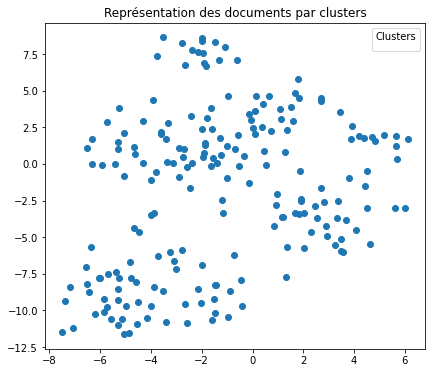

In [56]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_ts = tsne.fit_transform(d2v_kmeans.cluster_centers_)
plot_tsne(X_ts)


In [57]:


def show_cluster_terms(model, kmeans):
    """
    :param model: model.wv or model.dv
    :return:
    """
    print("Most representative terms per cluster (based on centroids):")
    for i in range(MAX_TAGS):
        tokens_per_cluster = ""
        most_representative = model.most_similar(positive=[kmeans.cluster_centers_[i]], topn=1)
        for t in most_representative:
            tokens_per_cluster += f"{docs_tags[t[0]]} "
        print(f"Cluster {i}: {tokens_per_cluster}")


In [58]:
d2v_model.dv.most_similar(positive=d2v_kmeans.cluster_centers_[0], topn=1)

[(23046, 0.9065751433372498)]

In [59]:
d2v_model.dv[21223]

array([ 0.36509243, -0.16111892, -0.03782053, -0.04028286, -0.16398428,
        0.01666306,  0.02445704,  0.00410702,  0.07413818,  0.06010888,
        0.11471201,  0.2545534 , -0.15898593,  0.06615129,  0.23467286,
        0.19988911,  0.04578475,  0.16538371,  0.09940466, -0.17203812,
       -0.01633385, -0.06373464,  0.07441019,  0.24453573, -0.08293886,
       -0.10194745, -0.2337096 , -0.01401276,  0.012747  , -0.37372446,
        0.15258147,  0.16580929, -0.2623852 ,  0.06521658,  0.04015636,
        0.11133134,  0.09888046, -0.14312111, -0.0673186 , -0.13063404,
       -0.31849366, -0.15496203,  0.03539116, -0.26107278,  0.23905432,
       -0.16689597,  0.02128544, -0.27655503,  0.14747867, -0.05847256],
      dtype=float32)

In [60]:
len(d2v_model.dv)
docs_reduced_body_sentences[21223]
docs_tags[21223]

27128

'python loop numpy array aware several question answer topic nt found answer particular problem easiest way simple python loop numpy array function looking efficient way wanted something simple implement nt require significant rewrite loop run parallel like implement lower level language best answer ve seen regard one rather way requires one express loop function take single argument several line converting seems require parallel function called main nt seem work well prompt lot time python really best way loop really something trivial read documentation module find general seems everything simple loop interested setting manager proxy pipe etc simple loop fully parallel nt communication task using simple situation seems like mention would case nt time learn different parallel package python wondering someone experience show simpler way please suggest technique already use using parallel function case general parallel'

['python', 'numpy']

In [61]:
show_cluster_terms(d2v_model.dv, d2v_kmeans)

Most representative terms per cluster (based on centroids):
Cluster 0: ['python', 'django', 'pip'] 
Cluster 1: ['python', 'machine-learning', 'neural-network', 'keras'] 
Cluster 2: ['javascript', 'node.js', 'express'] 
Cluster 3: ['python', 'ajax', 'django', 'json', 'templates'] 
Cluster 4: ['c++', 'hash'] 
Cluster 5: ['iphone', 'html'] 
Cluster 6: ['java'] 
Cluster 7: ['ios', 'iphone', 'swift'] 
Cluster 8: ['haskell', 'concurrency', 'functional-programming'] 
Cluster 9: ['iphone', 'uiview'] 
Cluster 10: ['android', 'multithreading', 'asynchronous'] 
Cluster 11: ['python', 'windows', 'linux'] 
Cluster 12: ['mysql', 'sql', 'performance'] 
Cluster 13: ['java', 'json', 'node.js', 'maven', 'npm'] 
Cluster 14: ['r'] 
Cluster 15: ['c', 'linux'] 
Cluster 16: ['scala', 'generics'] 
Cluster 17: ['.net', 'visual-studio'] 
Cluster 18: ['javascript', 'angularjs', 'unit-testing'] 
Cluster 19: ['apache'] 
Cluster 20: ['linux', 'macos', 'gcc'] 
Cluster 21: ['javascript', 'events'] 
Cluster 22: ['ios'

In [62]:
# TODO WIP 
# predict
# classify ?
# faire une reduction de dimension PCA ?

# sentence = ["topic", "python"]
# sentence = docs.reduced_body[789]
# sentence

# sentence_vector = np.mean([w2v_model.wv[w2v_model.wv.most_similar(word)[0][0]] for word in sentence], axis=0)
# sentence_vector


In [63]:
dummy_vector = np.random.uniform(low=-1, high=1, size=VECTOR_SIZE)
index = d2v_model.dv.most_similar(dummy_vector)[0]
index
docs_tags[index[0]]



# for vector in d2v_model.dv.vectors[:100]:
#     print(d2v_kmeans.predict([vector])[0])

(3108, 0.5767597556114197)

['javascript', 'function']

In [64]:
def get_most_similar_doc(sentence):
    sentence_vector = d2v_model.infer_vector([sentence])
    print(sentence_vector)    
    most_similar = d2v_model.dv.most_similar(sentence_vector)[0]
    return most_similar, docs_tags[most_similar[0]]

index = 4565
d2v_model.dv.vectors[index]
sentence = docs_reduced_body_sentences[index]
sentence
docs_tags[index]
d, t = get_most_similar_doc(sentence)
d
t

array([-0.01075789, -0.02962097,  0.05710796,  0.09784981, -0.08884569,
        0.00287643, -0.0844242 , -0.07733785, -0.06445917,  0.07955126,
        0.01920575,  0.10782835,  0.09501182, -0.04252931, -0.02218806,
       -0.13504405, -0.11741319,  0.1025411 , -0.14207244, -0.05175679,
        0.02476772,  0.03347047,  0.08168873,  0.076193  , -0.01229189,
       -0.00750845, -0.07115532, -0.00672177,  0.00100443, -0.01136258,
       -0.00735706,  0.02544365,  0.10024389,  0.00620736, -0.04997519,
        0.02849647, -0.00771997, -0.03732679, -0.0629384 , -0.0302149 ,
       -0.05667382, -0.05114607, -0.01261169, -0.02146343,  0.01699825,
        0.1204394 ,  0.07849295, -0.12741572,  0.12921868, -0.03802704],
      dtype=float32)

'xml schema ve seen several discussion net great would xml schema file least basic validation like idea eclipse never saw solution'

['java', 'xml']

[ 6.1411345e-03  2.9047870e-03 -6.7862179e-03 -7.6828348e-03
  7.8353193e-03  1.4235496e-03 -5.8753872e-03 -8.4522483e-04
  6.7537036e-03  2.4397015e-04  7.0669653e-04 -4.3687462e-03
 -4.8304922e-03 -8.4435986e-03  6.3939057e-03  9.3502970e-03
  4.6421290e-05  1.2871313e-03 -6.8658590e-03 -2.8299261e-03
  5.1121356e-04 -7.2164559e-03 -3.2911999e-03 -8.2695475e-03
  1.3511610e-03 -5.8447630e-03 -6.7708851e-03 -1.5478306e-03
  3.3491694e-03  4.1108942e-03  1.9692027e-03  7.7221082e-03
 -8.6601069e-03 -5.0482047e-03 -3.6032945e-03  8.3193593e-03
 -5.1748157e-03 -6.7875003e-03  9.6409712e-03  4.6787979e-03
 -1.6688257e-03  4.1092075e-03  4.1948925e-03 -1.3696962e-03
 -8.9203324e-03  6.3725724e-03  7.2806943e-03 -6.2965215e-03
 -1.6732401e-03  7.2327256e-04]


(15136, 0.20025783777236938)

['java', 'spring', 'rest', 'spring-mvc']

In [65]:

most_similar_doc = d2v_model.dv.most_similar(0)
most_similar_doc

[(25993, 0.8688204884529114),
 (23824, 0.8589234352111816),
 (5809, 0.8498507142066956),
 (24634, 0.8422409296035767),
 (14780, 0.829531192779541),
 (17774, 0.8238325715065002),
 (19973, 0.8234438896179199),
 (14893, 0.8228318691253662),
 (12644, 0.8226438760757446),
 (13302, 0.8174068927764893)]

## Embedding with BERT

In [176]:
import tensorflow as tf

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]        # [batch_size, 768].
sequence_output = outputs["sequence_output"]    # [batch_size, seq_length, 768].


FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on rocketstation. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

## Embedding with USE

<https://tfhub.dev/google/universal-sentence-encoder/4>

In [175]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
     "The quick brown fox jumps over the lazy dog.",
     "I am a sentence for which I would like to get its embedding"])

print(embeddings)

# The following are example embedding output of 512 dimensions per sentence
# Embedding for: The quick brown fox jumps over the lazy dog.
# [-0.03133016 -0.06338634 -0.01607501, ...]
# Embedding for: I am a sentence for which I would like to get its embedding.
# [0.05080863 -0.0165243   0.01573782, ...]


tf.Tensor(
[[-0.03133017 -0.06338634 -0.01607501 ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.0508086  -0.01652434  0.01573779 ...  0.00976657  0.03170121
   0.01788118]], shape=(2, 512), dtype=float32)


In [178]:
embedding_sentences_use = embed(docs_reduced_body_sentences)

2022-05-16 23:52:39.816389: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3863912960 exceeds 10% of free system memory.


In [ ]:
embedding_sentences_use.fit()

In [183]:
# todo : clusterize embedding, then score /  predict
tsne = manifold.TSNE(n_components=3, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(embedding_sentences_use)


In [185]:

# todo faire un grid search cv

kmeans_use_embedding = KMeans(n_clusters=MAX_TAGS, n_init=100, random_state=0)
kmeans_use_embedding.fit(X_tsne)

KMeans(n_clusters=200, n_init=100, random_state=0)

## Fonctions communes

In [173]:
from sklearn import cluster, metrics
from sklearn import manifold, decomposition


# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    num_labels=len(common_tags)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(docs_tags_mlb, cls.labels_),4)
    print("ARI : ", ARI)
    
    return ARI, X_tsne, cls.labels_



## Appendix

sample:

<https://www.analyticsvidhya.com/blog/2021/09/onevsrest-classifier-for-predicting-multiple-tags-of-research-articles/#h2_2>



à lire


topic modelling : unsupervised learning

topic classification : supervised learning


<https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/>

<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

<https://medium.com/le-blog-de-lapprentissage-automatique/pr%C3%A9diction-des-tags-des-questions-de-stack-overflow-9be00f7672f9>

Topic Modeling: Predicting Multiple Tags of Research Articles using OneVsRest strategy:

<https://www.analyticsvidhya.com/blog/2021/09/onevsrest-classifier-for-predicting-multiple-tags-of-research-articles/#h2_2>

Baeldung: Topic Modeling with Word2Vec

<https://www.baeldung.com/cs/ml-word2vec-topic-modeling>

Evaluating Multi-label Classifiers

<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>


Difference stemming lemmatization

<https://fr.quora.com/Quelle-est-la-diff%C3%A9rence-entre-le-stemming-et-la-lemmatisation>

Multi Label scoring

<https://medium.datadriveninvestor.com/predicting-tags-for-the-questions-in-stack-overflow-29438367261e>
<https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea>